In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Seed RNG (for reproducibility)
seed = 100
np.random.seed(seed)

In this experiement we will investigate the applicability of MAML to time series forecasting tasks, in particular whether the method allows a neural network model to adapt to non-stationarity in a stochastic process.

For this experiment we will target the AR(1) process $X_t$ given by:

$X_{t} = \alpha X_{t-1} + \epsilon_t$

where $\alpha \in \mathbb{R}$, $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$ are **i.i.d** noise terms with constant error variance $\sigma^2$.

The goal will be to vary $\alpha$ and $\sigma$ and see if a neural network forecasting model is able to rapidly adapt to new processes with different coefficients.

The following code snippet produces samples from an AR(1) process:

In [160]:
# Sample from AR(1) process.
def sample_ar_1(alpha, sigma, T=1000):
    ''' Sample T steps from an AR(1) process with noise variance sigma and AR-coefficient alpha'''
    noise = np.random.normal(0, sigma, T+1)
    X = np.zeros(T)

    for n in range(1,T):
        X[n] = (alpha*X[n-1]) + noise[n]
    return X

We illustrate the AR process with different settings of $\alpha$ sampled with constant error variance 2.
Notice how as $\alpha \rightarrow 1$ contribution from the previous term becomes more relevant compared to the noise, transforming it from an almost white-noise sequence for $\alpha=0.1$ to something with significant autocorrelation at $\alpha=0.9$.


Text(0, 0.5, 'Alpha = 0.1')

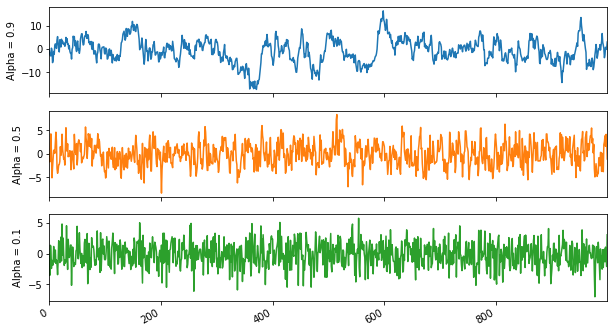

In [219]:
# Visualisation of an AR(1)
var = 2
df = pd.DataFrame()
df['a=0.9'] = sample_ar_1(0.9, var)
df['a=0.5'] = sample_ar_1(0.5, var)
df['a=0.1'] = sample_ar_1(0.1, var)
axes = df.plot(figsize=(10, 6), subplots=True, sharex=True, legend=False)
axes[0].set_ylabel('Alpha = 0.9')
axes[1].set_ylabel('Alpha = 0.5')
axes[2].set_ylabel('Alpha = 0.1')

It is simple to show the autocorrelation function of an AR(1) process is given by $\gamma(\delta) = \alpha^{\delta}$.
By inspection of $\gamma(\cdot)$ the process is unstable for $|\alpha|>1$ as shocks will be magnified over time (even if the mean is zero). 

We illustrate this below by taking just 30 samples of an AR(1) process with $\alpha=1.5$:

Text(0, 0.5, 'Alpha=1.5')

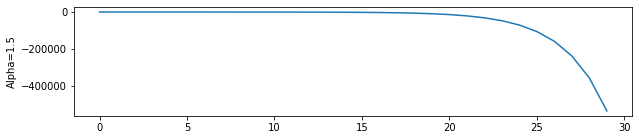

In [221]:
fig, axes = plt.subplots(figsize=(10,2))
axes.plot(sample_ar_1(1.5, var, 30)) #Unstable AR process
axes.set_ylabel('Alpha=1.5')

We will now verify if a simple ANN model can recover an AR(1) coefficient. The following Tensorflow code is adapted from https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb#scrollTo=q5P2yS3GB2aP. TODO: Better way to reference in Jup?

In [135]:
# The goal is to train NN to predict the next value given the current value
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import sklearn.metrics
import time

tf.keras.backend.set_floatx('float64')

class ARModel(keras.Model):
    '''Model to forecast the next value of a stochastic process'''
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [89]:
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    
def compute_loss(model, x, y, loss_fn=loss_function):
    preds = model.forward(x)
    mse = loss_fn(preds, y)
    return mse, preds


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = ARModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, x in enumerate(dataset): # dataset will be vector of time-series here
            loss = train_batch(x[:-1,None], x[1:,None], model, optimizer) # Training data is x_t, test is x_t+1 (hence the need to trim).
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

We fit the model to 1000 (randomly generated) batches of 1000 timesteps of an AR(1) process with $\alpha=0.8$.

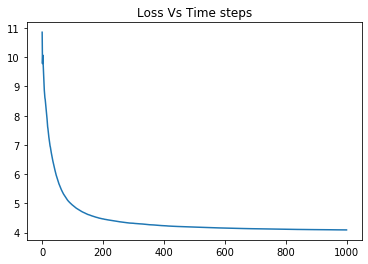

In [136]:
train_dataset = [sample_ar_1(0.8, 2, 1000) for i in range(1000)]
model = train_model(train_dataset)

We now compare the model forecast to the true optimal forecast (in terms of mean squared error), that is that conditional expectation: $\mathbb{E}[X_{t+1}|X_t=x] = 0.8x + 0 = 0.8x$.

0.5115919419138805
0.5093044856669899


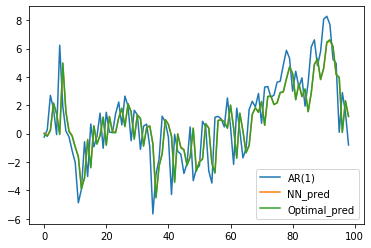

In [223]:
x = sample_ar_1(0.8, 2, 100)
y = model.forward(tf.convert_to_tensor(x[:,None]))

# Benchmark - linear forecast
lin = np.zeros(len(x))
lin[1:] = 0.8*x[:-1]

plt.plot(x[1:], label='AR(1)')
plt.plot(y[:-1], label='NN_pred')
plt.plot(lin[1:], label='Optimal_pred')
plt.legend()
print(sklearn.metrics.r2_score(x[1:], y[:-1]))
print(sklearn.metrics.r2_score(x[1:], lin[1:]))

Graphically the two are near indistinguishable with very similar $R^2$ scores. We repeat this trial 1000 times and evaluate the mean and variance of the difference of these two scores.

In [227]:
scores = np.zeros(1000)
for i in range(len(scores)):
    x = sample_ar_1(0.8, 2, 100)
    y = model.forward(tf.convert_to_tensor(x[:,None]))

    # Benchmark - linear forecast
    lin = np.zeros(len(x))
    lin[1:] = 0.8*x[:-1]
    scores[i] = sklearn.metrics.r2_score(x[1:], lin[1:]) - sklearn.metrics.r2_score(x[1:], y[:-1])

print('Mean: {}'.format(scores.mean()))
print('Var: {}'.format(scores.var()))

Mean: -5.142751826246328e-05
Var: 5.136637197661588e-06


We observe that the difference is almost indistinguishable with incredibly low variability and hence that the ANN model is able to learn $\alpha$ to near machine precision (this is not surprising).